In [31]:
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import os
import math
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score
import seaborn as sns
from sklearn import metrics
import time
import pickle
import metric_learn
from sklearn.decomposition import PCA  
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
import functools
import tempfile
import datetime
import tensorflow as tf
import mlflow
from mlflow.models import infer_signature
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.python.client import device_lib; print(device_lib.list_local_devices())
import tensorflow as tf
tf.config.list_physical_devices('GPU')
from utils import make_data, make_data_rev, make_label, calc_leq, leq_filter, validate, figure, figure_detail, plot_timeseries, fig_pr, auc_gs, fig_th_f

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5245193240273228467
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2777348096
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3129933696718315508
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [32]:
data_dir='semi_train_data'
semi_train_df= pd.read_csv( os.path.join(data_dir, 'semi_train_df_pred.csv'), index_col=0 )
semi_train_df

original  day      pred  label
0            53.6    0  0.199618      0
1            54.0    0  0.151213      0
2            54.7    0  0.164040      0
3            55.7    0  0.181788      0
4            55.5    0  0.236920      0
...           ...  ...       ...    ...
2393381      45.0    5  0.117259      0
2393382      45.2    5  0.091667      0
2393383      45.1    5  0.050000      0
2393384      45.1    5  0.000000      0
2393385      46.0    5  0.157313      0

[2393386 rows x 4 columns]

In [33]:
test_day=[6, 7, 8, 9]
semi_train_day=[0, 1, 2, 3, 4, 5]
labeling_day_num=1
cv_comb=np.array(semi_train_day).reshape((-1, labeling_day_num)).tolist()
cv_comb

[[0], [1], [2], [3], [4], [5]]

In [34]:
for i in cv_comb:
    label_train_day=[k for k in semi_train_day if k not in i]
    label_grant_day=i
    print(f'訓練データ：{label_train_day}')
    print(f'ラベル付与データ：{label_grant_day}日目')
    d = semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), 'pred'].values
    
    #閾値設定
    #kmeans
    n_clusters=2
    #init default=’k-means++’
    model = KMeans(n_clusters=n_clusters, n_init=10)  
    model.fit(d.reshape((-1, 1)))
    clusters = model.predict(d.reshape((-1, 1)))  
    result=pd.DataFrame({'d':d, 'cluster':clusters})
    thr_list=[]
    for j in range(n_clusters):
        thr_list.append(result.loc[result['cluster']==j, 'd'].max())
    thr_min=sorted(thr_list)[-2]
    thr_max=sorted(thr_list)[-1]
    thr_range=result.loc[(result['d']>thr_min)&(result['d']<=thr_max), ['d']]
    Q1 = float(thr_range.quantile(0.25).iloc[0])
    Q3 = float(thr_range.quantile(0.75).iloc[0])
    IQR = Q3 - Q1
    thr = min(float(Q3 + 1.5 * IQR), thr_max)
    print(thr)
    weight=d.copy()
    
    max=100000
    w_scaler=MinMaxScaler(feature_range=(1, max))
    weight=w_scaler.fit_transform(d.reshape(-1, 1)).ravel()
    semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), 'weight']\
    = np.where(d>=thr, 1/weight, weight)
    print('------------------------------------------------------')
semi_train_df_tmp=semi_train_df[['original', 'day', 'weight', 'label']]
semi_train_df_tmp.to_csv('semi_train_data/semi_train_df_weight.csv')

訓練データ：[1, 2, 3, 4, 5]
ラベル付与データ：[0]日目
2.0722939521953667
------------------------------------------------------
訓練データ：[0, 2, 3, 4, 5]
ラベル付与データ：[1]日目
2.39730982350639
------------------------------------------------------
訓練データ：[0, 1, 3, 4, 5]
ラベル付与データ：[2]日目
1.7095292857222748
------------------------------------------------------
訓練データ：[0, 1, 2, 4, 5]
ラベル付与データ：[3]日目
2.4377808397180005
------------------------------------------------------
訓練データ：[0, 1, 2, 3, 5]
ラベル付与データ：[4]日目
2.4518839510984414
------------------------------------------------------
訓練データ：[0, 1, 2, 3, 4]
ラベル付与データ：[5]日目
2.019050296286455
------------------------------------------------------


## conv1dAE

In [60]:
data_dir='semi_train_data'
semi_train_df= pd.read_csv( os.path.join(data_dir, 'semi_train_df_weight.csv'), index_col=0 )
semi_train_df

original  day       weight  label
0            53.6    0  1751.393497      0
1            54.0    0  1326.940299      0
2            54.7    0  1439.420721      0
3            55.7    0  1595.044702      0
4            55.5    0  2078.477174      0
...           ...  ...          ...    ...
2393381      45.0    5  1326.711695      0
2393382      45.2    5  1037.369723      0
2393383      45.1    5   566.292576      0
2393384      45.1    5     1.000000      0
2393385      46.0    5  1779.559891      0

[2393386 rows x 4 columns]

In [61]:
df_list=[]

window=16
for i in set(semi_train_df['day']):
    lag=[] 
    lag.append(make_data_rev(semi_train_df.loc[semi_train_df['day']==i, ['original']], 'original', window))
    lag.append(semi_train_df.loc[semi_train_df['day']==i, ['weight']])
    lag.append(semi_train_df.loc[semi_train_df['day']==i, ['day']])
    lag.append(semi_train_df.loc[semi_train_df['day']==i, ['label']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
semi_train_df=pd.concat(df_list)
semi_train_df=semi_train_df.dropna().reset_index(drop=True)
semi_train_df.loc[:, 'convaed']=0
semi_train_df.loc[:, 'convaed_label']=0

In [62]:
semi_train_df

original  original_next1  original_next2  original_next3  \
0            53.6            54.0            54.7            55.7   
1            54.0            54.7            55.7            55.5   
2            54.7            55.7            55.5            55.7   
3            55.7            55.5            55.7            55.6   
4            55.5            55.7            55.6            55.8   
...           ...             ...             ...             ...   
2393291      45.3            45.2            45.0            44.6   
2393292      45.2            45.0            44.6            45.2   
2393293      45.0            44.6            45.2            44.9   
2393294      44.6            45.2            44.9            44.9   
2393295      45.2            44.9            44.9            45.1   

         original_next4  original_next5  original_next6  original_next7  \
0                  55.5            55.7            55.6            55.8   
1                  55.7            55.6            55.8            55.7   
2                  55.6            55.8            55.7            55.0   
3                  55.8            55.7            55.0            54.9   
4                  55.7            55.0            54.9            54.9   
...                 ...             ...             ...             ...   
2393291            45.2            44.9            44.9            45.1   
2393292            44.9            44.9            45.1            45.7   
2393293            44.9            45.1            45.7            45.0   
2393294            45.1            45.7            45.0            45.6   
2393295            45.7            45.0            45.6            45.4   

         original_next8  original_next9  ...  original_next11  \
0                  55.7            55.0  ...             54.9   
1                  55.0            54.9  ...             54.9   
2                  54.9            54.9  ...             55.0   
3                  54.9            54.9  ...             55.0   
4                  54.9            55.0  ...             55.2   
...                 ...             ...  ...              ...   
2393291            45.7            45.0  ...             45.4   
2393292            45.0            45.6  ...             44.8   
2393293            45.6            45.4  ...             45.1   
2393294            45.4            44.8  ...             45.4   
2393295            44.8            45.1  ...             45.0   

         original_next12  original_next13  original_next14  original_next15  \
0                   54.9             55.0             55.0             55.2   
1                   55.0             55.0             55.2             54.7   
2                   55.0             55.2             54.7             54.4   
3                   55.2             54.7             54.4             54.5   
4                   54.7             54.4             54.5             54.3   
...                  ...              ...              ...              ...   
2393291             44.8             45.1             45.4             45.0   
2393292             45.1             45.4             45.0             45.2   
2393293             45.4             45.0             45.2             45.1   
2393294             45.0             45.2             45.1             45.1   
2393295             45.2             45.1             45.1             46.0   

              weight  day  label  convaed  convaed_label  
0        1751.393497    0      0        0              0  
1        1326.940299    0      0        0              0  
2        1439.420721    0      0        0              0  
3        1595.044702    0      0        0              0  
4        2078.477174    0      0        0              0  
...              ...  ...    ...      ...            ...  
2393291   943.154294    5      0        0              0  
2393292   943.154294    5      0        0              0  
2393293   943.1542

## Conv1D_autoencoder

In [63]:
# padding=sameは元の入力と同じ長さを出力がもつように入力にパディングする．
# （※正確には，入力の大きさをstridesの大きさで単純に割ったものが出力の大きさになる）
input_filter=4
latent_filter=22
kernel_size=6

class Conv_Autoencode(Model):
    def __init__(self):
        super().__init__()
        self.enc_dec = keras.Sequential(
                [
                    layers.Conv1D(
                        filters=input_filter,
                        kernel_size=kernel_size,
                        padding="same",
                        strides=2,
                        activation="relu",
                    ),

                    layers.Conv1D(
                        filters=latent_filter,
                        kernel_size=kernel_size,
                        padding="same",
                        strides=2,
                        activation="relu",
                    ),
                    layers.Conv1DTranspose(
                        filters=latent_filter,
                        kernel_size=kernel_size,
                        padding="same",
                        strides=2,
                        activation="relu",
                    ),

                    layers.Conv1DTranspose(
                        filters=input_filter,
                        kernel_size=kernel_size,
                        padding="same",
                        strides=2,
                        activation="relu",
                    ),
                    layers.Conv1DTranspose(filters=1, kernel_size=kernel_size, padding="same"),
                ]
            )

    def call(self, x):
        return self.enc_dec(x[:, :-1])

# カスタム損失
def custom_loss(y_true, y_pred):
    mae=tf.math.reduce_mean(tf.abs(y_true[:, :-1] - y_pred))
    pena=tf.math.reduce_mean(tf.abs(y_true[:, :-1] - y_pred)*y_true[:, -1:])
    
#     return mae
    return mae+pena

訓練データ：[0, 1, 2, 3, 5]
ラベル付与データ：[4]日目
Epoch 1/5
3831/3831 [==============================] - 17s 4ms/step - loss: 115.1484 - val_loss: 32.6734
Epoch 2/5
3831/3831 [==============================] - 17s 4ms/step - loss: 47.7989 - val_loss: 19.7356
Epoch 3/5
3831/3831 [==============================] - 17s 4ms/step - loss: 33.0435 - val_loss: 13.6776
Epoch 4/5
3831/3831 [==============================] - 17s 4ms/step - loss: 26.0754 - val_loss: 10.2981
Epoch 5/5
3831/3831 [==============================] - 17s 4ms/step - loss: 23.0303 - val_loss: 8.3464


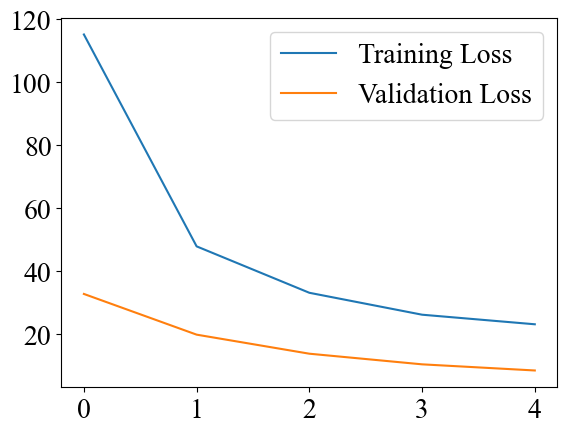

13499/13499 [==============================] - 17s 1ms/step
------------------------------------------------------


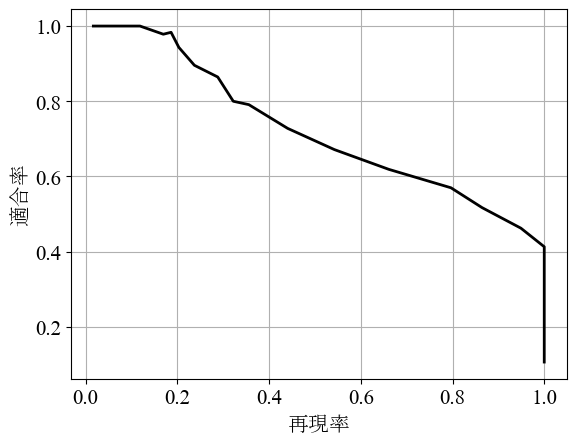

AUC：0.70931710125468
理想の閾値：0.16
F値（最高）：0.6644593351727763
適合率（F値が最高の時）：0.5699152542372882
再現率（F値が最高の時）：0.7966101694915254


In [64]:
# テストデータとする日
i=[4]
label_train_day=[k for k in semi_train_day if k not in i]
label_grant_day=i
print(f'訓練データ：{label_train_day}')
print(f'ラベル付与データ：{label_grant_day}日目')

semi_train_x=semi_train_df[(semi_train_df['day'].isin(label_train_day))][semi_train_df.columns[:-4]].reset_index(drop=True)
labeling_x=semi_train_df[(semi_train_df['day'].isin(label_grant_day))][semi_train_df.columns[:-4]].reset_index(drop=True)

train_weight=semi_train_x[['weight']].values
semi_train_x.drop(columns='weight', inplace=True)
labeling_weight=labeling_x[['weight']].values
labeling_x.drop(columns='weight', inplace=True)

train_mean=semi_train_x['original'].mean()
train_std=semi_train_x['original'].std()

#標準化
train_data = (semi_train_x.values-train_mean)/train_std
labeling_data = (labeling_x.values -train_mean) / train_std

train_data =np.hstack([train_data , train_weight])
labeling_data =np.hstack([labeling_data , labeling_weight])

# データをモデルに入力する形状に整形し,データの型をtf.float32に変換
train_data = tf.cast(train_data[:, :, np.newaxis], tf.float32)
labeling_data = tf.cast(labeling_data[:, :, np.newaxis], tf.float32)


conv_autoencoder=Conv_Autoencode()  
conv_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                         loss=custom_loss)

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    restore_best_weights=True
)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = conv_autoencoder.fit(train_data, train_data, 
      epochs=5, 
      batch_size=512,
      validation_data=(labeling_data, labeling_data),
      callbacks=[callback],
      shuffle=True)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

reconstructions = conv_autoencoder.predict(labeling_data)
#     異常度算出
d= tf.keras.losses.mae(reconstructions[:, :, 0], labeling_data[:, :-1, 0]).numpy()
semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), 'convaed']=d
print('------------------------------------------------------')

test_v=semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), ['original', 'label']].copy().reset_index(drop=True)
d_test=(d-d.min())/(d.max()-d.min())

thr_bins=20
p_score, r_score, f_score, thresholds, thr, auc = fig_pr(test_v, d_test, thr_bins)
f_max=f_score.max()
p_max=p_score[np.argmax(f_score)]
r_max=r_score[np.argmax(f_score)]
print('\033[31m'+f'AUC：{auc}'+'\033[0m')
print(f'理想の閾値：{thr}')
print(f'F値（最高）：{f_max}')
print(f'適合率（F値が最高の時）：{p_max}')
print(f'再現率（F値が最高の時）：{r_max}')
plot_timeseries([test_v['original'].values], test_v['label'].values, d=d_test, thr=thr)

